In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import scipy as scp
import sklearn
import sys, os, pickle

sys.path.append(os.path.join('..'))

from FACT.helper import *
from FACT.fairness import *
from FACT.data_util import *
from FACT.plot import *
from FACT.lin_opt import *
from FACT.postprocess import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm 

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
np.set_printoptions(threshold=np.inf)

%matplotlib inline
import warnings; warnings.simplefilter('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
def post_process_sol(zz, fm, seed =0 ): 
# base classifier
    fpr_base_pos = fm.pos_group_stats['FPR']
    tpr_base_pos = fm.pos_group_stats['TPR']
    fnr_base_pos = fm.pos_group_stats['FNR']
    tnr_base_pos = fm.pos_group_stats['TNR']
    fpr_base_neg = fm.neg_group_stats['FPR']
    tpr_base_neg = fm.neg_group_stats['TPR']
    fnr_base_neg = fm.neg_group_stats['FNR']
    tnr_base_neg = fm.neg_group_stats['TNR']

    # derived classifier
    fpr_der_pos = zz[2] / (zz[2] + zz[3])
    tpr_der_pos = zz[0] / (zz[0] + zz[1])
    fnr_der_pos = 1 - tpr_der_pos
    tnr_der_pos = 1 - fpr_der_pos
    fpr_der_neg = zz[6] / (zz[6] + zz[7])
    tpr_der_neg = zz[4] / (zz[4] + zz[5])
    fnr_der_neg = 1 - tpr_der_neg
    tnr_der_neg = 1 - fpr_der_neg

    # print(fpr_der_pos, fnr_der_pos, fpr_der_neg, fnr_der_neg)

    # get mixing rates
    mix_mat_pos = np.array([[tpr_base_pos, fnr_base_pos, 0, 0], [fpr_base_pos, tnr_base_pos, 0, 0], [0, 0, tpr_base_pos, fnr_base_pos], [0, 0, fpr_base_pos, tnr_base_pos]])
    mix_b_pos = np.array([tpr_der_pos, fpr_der_pos, fnr_der_pos, tnr_der_pos])
    mix_sol_pos = np.linalg.solve(mix_mat_pos, mix_b_pos)
    mix_mat_neg = np.array([[tpr_base_neg, fnr_base_neg, 0, 0], [fpr_base_neg, tnr_base_neg, 0, 0], [0, 0, tpr_base_neg, fnr_base_neg], [0, 0, fpr_base_neg, tnr_base_neg]])
    mix_b_neg = np.array([tpr_der_neg, fpr_der_neg, fnr_der_neg, tnr_der_neg])
    mix_sol_neg = np.linalg.solve(mix_mat_neg, mix_b_neg)
    p2p_pos, n2p_pos, p2n_pos, n2n_pos = mix_sol_pos
    assert (p2p_pos >= 0 and p2p_pos <= 1)
    assert (n2p_pos >= 0 and n2p_pos <= 1)
    p2p_neg, n2p_neg, p2n_neg, n2n_neg = mix_sol_neg

    # Post-process accordingly
    pos_pred = fm.y_pred[fm.pos_group]
    pos_pred_fair = pos_pred.copy()
    pos_pp_indices, = np.nonzero(pos_pred)
    pos_pn_indices, = np.nonzero(1 - pos_pred)
    np.random.seed(seed)
    np.random.shuffle(pos_pp_indices)
    np.random.seed(seed)
    np.random.shuffle(pos_pn_indices)
    n2p_indices = pos_pn_indices[:int(len(pos_pn_indices) * n2p_pos)]
    pos_pred_fair[n2p_indices] = 1 - pos_pred_fair[n2p_indices]
    p2n_indices = pos_pp_indices[:int(len(pos_pp_indices) * (1 - p2p_pos))]
    pos_pred_fair[p2n_indices] = 1 - pos_pred_fair[p2n_indices]

    neg_pred = fm.y_pred[fm.neg_group]
    neg_pred_fair = neg_pred.copy()
    neg_pp_indices, = np.nonzero(neg_pred)
    neg_pn_indices, = np.nonzero(1 - neg_pred)
    np.random.shuffle(neg_pp_indices)
    np.random.shuffle(neg_pn_indices)
    n2p_indices = neg_pn_indices[:int(len(neg_pn_indices) * n2p_neg)]
    neg_pred_fair[n2p_indices] = 1 - neg_pred_fair[n2p_indices]
    p2n_indices = neg_pp_indices[:int(len(neg_pp_indices) * (1 - p2p_neg))]
    neg_pred_fair[p2n_indices] = 1 - neg_pred_fair[p2n_indices]

    # EOd gap and accuracy
    fn_pos = np.where(pos_pred_fair - fm.y_test[fm.pos_group] == -1)[0].shape[0]
    fp_pos = np.where(pos_pred_fair - fm.y_test[fm.pos_group] == 1)[0].shape[0]
    eod_pos = (fn_pos / fm.pos_group_num, fp_pos / fm.pos_group_num)

    fn_neg = np.where(neg_pred_fair - fm.y_test[fm.neg_group] == -1)[0].shape[0]
    fp_neg = np.where(neg_pred_fair - fm.y_test[fm.neg_group] == 1)[0].shape[0]
    eod_neg = (fn_neg / fm.neg_group_num, fp_neg / fm.neg_group_num)

    eod_gap = np.abs(eod_pos[0] - eod_neg[0]) + np.abs(eod_pos[1] - eod_neg[1])
    meo = eod_gap/2
    acc = 1 - (fn_pos + fp_pos + fn_neg + fp_neg) / fm.y_test.shape[0] 

    # print(fn_pos, fp_pos, fn_neg, fp_neg)
    # print(p2p_pos, n2p_pos, p2p_neg, n2p_neg)
    # print(int(len(pos_pp_indices) * (1 - p2p_pos)), len(pos_pp_indices))
    # print(len(pos_pp_indices[:-1053]))
    # print(tpr_base_pos, tpr_base_neg, tnr_base_pos, tnr_base_neg)
    return acc, meo

In [53]:
with open('adult-logit.pkl', 'rb') as f:
    model = pickle.load(f)

In [56]:
model.best_params_

{'logisticregression__C': 0.1}

In [94]:
dataname = 'hsls'
model_name = 'logit'
fair = 'eo'
rand_seed =42

X_train, y_train, X_test, y_test, X_train_removed, X_test_removed, dtypes, dtypes_, sens_idc, race_idx, sex_idx = get_dataset(dataname, seed= 0)

if model_name == 'gbm': 
    model = GradientBoostingClassifier(random_state=rand_seed)
elif model_name == 'logit': 
    model = LogisticRegression(random_state=rand_seed, C=1)
elif model_name == 'rf':
    model = RandomForestClassifier(random_state=rand_seed, n_estimators=10, min_samples_leaf=10)
else: 
    print('Error: Undefined Model')

model.fit(X_train_removed, y_train)
fm = FairnessMeasures(X_train, y_train, X_test, y_test, X_train_removed, X_test_removed, 
                        model, sens_idc, pos_label=1, neg_label=0)

_, mats_dict, M_const, b_const = get_fairness_mats(fm)
# Post process
if fair == 'eo':
    A, b = mats_dict['EqOdd']
A_const = M_const


In [96]:
eps_vals = np.logspace(0, -4, 20)

eps_used = []
acc_vals = []
sol_list = []
acc_actual = []
fair_actual = [] 
for eps in eps_vals:
    try:
        res, sol = model_spec_solve(A, b, A_const, b_const, fm, eps=eps)
        acc, fair = post_process_sol(sol.value, fm)
        acc_actual.append(acc)
        fair_actual.append(fair)
        acc_vals.append(1 - res.value)
        sol_list.append(sol.value)
        eps_used.append(eps)

    except:
        print('Fail: {:.4f}'.format(eps))
        continue


    
    # print(fpr_der_pos, fnr_der_pos, fpr_der_neg, fnr_der_neg)
    # print(fn_pos, fp_pos, fn_neg, fp_neg)
    # print(p2p_pos, n2p_pos, p2p_neg, n2p_neg)



Fail: 1.0000
Fail: 0.6158
Fail: 0.3793
Fail: 0.2336
Fail: 0.1438
Fail: 0.0886
Fail: 0.0007
Fail: 0.0004


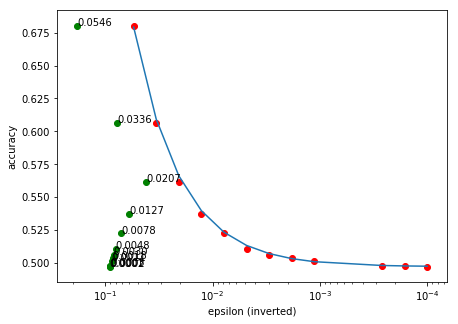

In [98]:
f, axs = plt.subplots(figsize=(7,5))
axs.semilogx(eps_used, acc_vals)
# x = np.log(post_process_meo)
axs.scatter(eps_used, acc_actual, color='red')
axs.scatter(fair_actual, acc_actual, color='green')


axs.invert_xaxis()
axs.set_xlabel('epsilon (inverted)')
axs.set_ylabel('accuracy')

annotations = ['{:.4f}'.format(x) for x in eps_used]
for i, label in enumerate(annotations):
    plt.annotate(label, (fair_actual[i], acc_actual[i]))


In [168]:



eps_vals = np.logspace(0, -2, 10)

acc_list = []
fair_list = [] 
for eps in eps_vals:
    print('epsilon={:.2f}'.format(eps))
    sol_list = []
    post_process_acc, post_process_meo = [], []
    for i in range(1):
        X_train, y_train, X_test, y_test, X_train_removed, X_test_removed, dtypes, dtypes_, sens_idc, race_idx, sex_idx = get_dataset(dataname, seed= i)

        if model_name == 'gbm': 
            model = GradientBoostingClassifier(random_state=rand_seed)
        elif model_name == 'logit': 
            model = LogisticRegression(random_state=rand_seed)
        elif model_name == 'rf':
            model = RandomForestClassifier(random_state=rand_seed, n_estimators=10, min_samples_leaf=10)
        else: 
            print('Error: Undefined Model')

        model.fit(X_train_removed, y_train)
        fm = FairnessMeasures(X_train, y_train, X_test, y_test, X_train_removed, X_test_removed, 
                                model, sex_idx, pos_label=1, neg_label=0)

        _, mats_dict, M_const, b_const = get_fairness_mats(fm)

        # Post process
        if fair == 'eo':
            A, b = mats_dict['EqOdd']
        A_const = M_const

        try:
            res, sol = model_spec_solve(A, b, A_const, b_const, fm, eps=eps)
            if res.status == 'infeasible':
                print('early quit: %f'%eps)
                break
        except:
            continue


        acc, fair = post_process_sol(sol.value, fm)
        print(acc, 1 - res.value)
        post_process_acc.append(np.mean(acc))
        post_process_meo.append(np.mean(fair))
    
    acc_list.append(post_process_acc)
    fair_list.append(post_process_meo)
    # print(idx, np.mean(fact_sol_eps), np.mean(fact_sol_acc), acc_vals[idx])
        


result_dict = {'eps': eps_vals, 'acc': acc_list, 'meo': fair_list}

filename = 'FACT_' + dataname + '_' + model_name + '.pkl'
with open(filename, 'wb') as f:
    results = pickle.dump(result_dict, f)

epsilon=1.00
87 4270 12 2724
0.3365287588294652 0.2 0.9455467372134039 0.9843260188087775
0.2739277305763128 0.894052615383345
epsilon=0.60
54 4261 17 2722
0.33148335015136227 0.1868421052631579 0.951058201058201 0.9853709508881923
0.2779199508649811 0.8984542941534841
epsilon=0.36
88 4266 14 2710
0.34056508577194755 0.19736842105263158 0.9429012345679012 0.9832810867293625
0.2754631999181083 0.8918005936803767
epsilon=0.22
82 4299 24 2687
0.3274470232088799 0.1736842105263158 0.9539241622574955 0.9839777081156391
0.27403009519909916 0.9007063158403766
epsilon=0.13
74 4253 12 2712
0.34056508577194755 0.2 0.9431216931216931 0.9832810867293625
0.27822704473334015 0.8918005936652215
epsilon=0.08
74 4253 14 2710
0.34056508577194755 0.19736842105263158 0.9431216931216931 0.9832810867293625
0.27822704473334015 0.8919029582762948
epsilon=0.05
69 4258 14 2718
0.3329969727547931 0.18947368421052632 0.9479717813051146 0.985022640195054
0.2774081277510493 0.8965093662573814
epsilon=0.03
74 4253 1

In [126]:
result_dict = {'eps': eps_vals, 'acc': acc_list, 'meo': fair_list}

In [155]:
dataname = 'adult'
model_name = 'logit'
filename = 'FACT_' + dataname + '_' + model_name + '.pkl'
with open(filename, 'rb') as f:
    results = pickle.load(f)


# X_train, y_train, X_test, y_test, X_train_removed, X_test_removed, dtypes, dtypes_, sens_idc, race_idx, sex_idx = get_dataset(dataname, seed= 42)

In [158]:
np.mean(results['acc'], axis=1)

array([0.27573958, 0.27472617, 0.27659945, 0.27594431, 0.27646637,
       0.27603644, 0.27693725, 0.2767837 , 0.27617975, 0.41805712])

In [131]:
np.mean(results['meo'])

0.0474639678344094

In [127]:
filename = 'FACT_' + dataname + '_' + model_name + '.pkl'
with open(filename, 'wb') as f:
    pickle.dump(result_dict, f)

<ErrorbarContainer object of 3 artists>

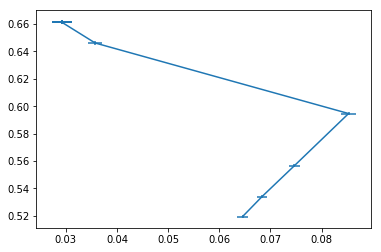

In [123]:
plt.errorbar(x=[np.mean(x) for x in fair_list], y= [np.mean(x) for x in acc_list], 
xerr= [np.std(x)/np.sqrt(10) for x in fair_list], yerr = [np.std(x)/np.sqrt(10) for x in acc_list])


In [144]:
model.fit(X_train_removed, y_train)
fm = FairnessMeasures(X_train, y_train, X_test, y_test, X_train_removed, X_test_removed, 
                        model, sex_idx, pos_label=1, neg_label=0)

_, mats_dict, M_const, b_const = get_fairness_mats(fm)

# Post process
A, b = mats_dict['EqOdd']
A_const = M_const


In [147]:
eps_vals = np.logspace(0, -6, 100)
eps_used = []
acc_vals = []
sol_list = []
for eps in eps_vals:
    try:
        
        res, sol = model_spec_solve(A, b, A_const, b_const, fm, eps=eps)
        acc_vals.append(1 - res.value)
        eps_used.append(eps)
        sol_list.append(sol.value)
    except:
        continue

# plt.savefig('enem_epsilon')

Text(0, 0.5, 'accuracy')

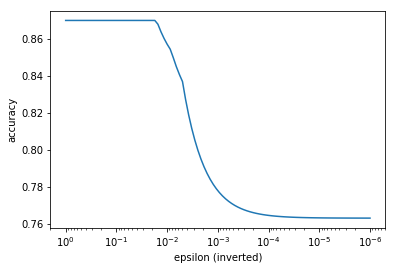

In [148]:
f, axs = plt.subplots()
axs.semilogx(eps_used, acc_vals)
axs.invert_xaxis()
axs.set_xlabel('epsilon (inverted)')
axs.set_ylabel('accuracy')

In [149]:
post_process_acc, post_process_meo = [], []
for idx, zz in enumerate(sol_list): 
    # base classifier
    fpr_base_pos = fm.pos_group_stats['FPR']
    tpr_base_pos = fm.pos_group_stats['TPR']
    fnr_base_pos = fm.pos_group_stats['FNR']
    tnr_base_pos = fm.pos_group_stats['TNR']
    fpr_base_neg = fm.neg_group_stats['FPR']
    tpr_base_neg = fm.neg_group_stats['TPR']
    fnr_base_neg = fm.neg_group_stats['FNR']
    tnr_base_neg = fm.neg_group_stats['TNR']

    # derived classifier
    fpr_der_pos = zz[2] / (zz[2] + zz[3])
    tpr_der_pos = zz[0] / (zz[0] + zz[1])
    fnr_der_pos = 1 - tpr_der_pos
    tnr_der_pos = 1 - fpr_der_pos
    fpr_der_neg = zz[6] / (zz[6] + zz[7])
    tpr_der_neg = zz[4] / (zz[4] + zz[5])
    fnr_der_neg = 1 - tpr_der_neg
    tnr_der_neg = 1 - fpr_der_neg

    fact_sol_eps, fact_sol_acc = [], [] 

    for i in range(10):

        # get mixing rates
        mix_mat_pos = np.array([[tpr_base_pos, fnr_base_pos, 0, 0], [fpr_base_pos, tnr_base_pos, 0, 0], [0, 0, tpr_base_pos, fnr_base_pos], [0, 0, fpr_base_pos, tnr_base_pos]])
        mix_b_pos = np.array([tpr_der_pos, fpr_der_pos, fnr_der_pos, tnr_der_pos])
        mix_sol_pos = np.linalg.solve(mix_mat_pos, mix_b_pos)
        mix_mat_neg = np.array([[tpr_base_neg, fnr_base_neg, 0, 0], [fpr_base_neg, tnr_base_neg, 0, 0], [0, 0, tpr_base_neg, fnr_base_neg], [0, 0, fpr_base_neg, tnr_base_neg]])
        mix_b_neg = np.array([tpr_der_neg, fpr_der_neg, fnr_der_neg, tnr_der_neg])
        mix_sol_neg = np.linalg.solve(mix_mat_neg, mix_b_neg)
        p2p_pos, n2p_pos, p2n_pos, n2n_pos = mix_sol_pos
        p2p_neg, n2p_neg, p2n_neg, n2n_neg = mix_sol_neg

        # Post-process accordingly
        pos_pred = fm.y_pred[fm.pos_group]
        pos_pred_fair = pos_pred.copy()
        pos_pp_indices, = np.nonzero(pos_pred)
        pos_pn_indices, = np.nonzero(1 - pos_pred)
        np.random.seed(i)
        np.random.shuffle(pos_pp_indices)
        np.random.seed(i)
        np.random.shuffle(pos_pn_indices)
        n2p_indices = pos_pn_indices[:int(len(pos_pn_indices) * n2p_pos)]
        pos_pred_fair[n2p_indices] = 1 - pos_pred_fair[n2p_indices]
        p2n_indices = pos_pp_indices[:int(len(pos_pp_indices) * (1 - p2p_pos))]
        pos_pred_fair[p2n_indices] = 1 - pos_pred_fair[p2n_indices]

        neg_pred = fm.y_pred[fm.neg_group]
        neg_pred_fair = neg_pred.copy()
        neg_pp_indices, = np.nonzero(neg_pred)
        neg_pn_indices, = np.nonzero(1 - neg_pred)
        np.random.shuffle(neg_pp_indices)
        np.random.shuffle(neg_pn_indices)
        n2p_indices = neg_pn_indices[:int(len(neg_pn_indices) * n2p_neg)]
        neg_pred_fair[n2p_indices] = 1 - neg_pred_fair[n2p_indices]
        p2n_indices = neg_pp_indices[:int(len(neg_pp_indices) * (1 - p2p_neg))]
        neg_pred_fair[p2n_indices] = 1 - neg_pred_fair[p2n_indices]

        # EOd gap and accuracy
        fn_pos = np.where(pos_pred_fair - fm.y_test[fm.pos_group] == -1)[0].shape[0]
        fp_pos = np.where(pos_pred_fair - fm.y_test[fm.pos_group] == 1)[0].shape[0]
        eod_pos = (fn_pos / fm.pos_group_num, fp_pos / fm.pos_group_num)

        fn_neg = np.where(neg_pred_fair - fm.y_test[fm.neg_group] == -1)[0].shape[0]
        fp_neg = np.where(neg_pred_fair - fm.y_test[fm.neg_group] == 1)[0].shape[0]
        eod_neg = (fn_neg / fm.neg_group_num, fp_neg / fm.neg_group_num)

        eod_gap = np.abs(eod_pos[0] - eod_neg[0]) + np.abs(eod_pos[1] - eod_neg[1])
        meo = eod_gap/2
        acc = 1 - (fn_pos + fp_pos + fn_neg + fp_neg) / fm.y_test.shape[0] 
        # print(eod_gap, acc)

        fact_sol_eps.append(meo)
        fact_sol_acc.append(acc)
    
    post_process_acc.append(np.mean(fact_sol_acc))
    post_process_meo.append(np.mean(fact_sol_eps))

    # print(idx, np.mean(fact_sol_eps), np.mean(fact_sol_acc), acc_vals[idx])
        


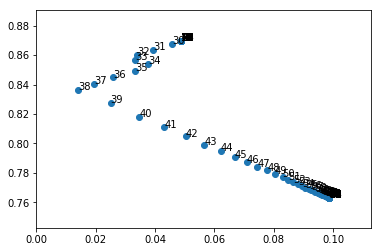

In [151]:
plt.scatter(post_process_meo, post_process_acc)

annotations = ['{:.2f}'.format(x) for x in np.log10(eps_used)]
for i, label in enumerate(annotations):
    plt.annotate(str(i), (post_process_meo[i], post_process_acc[i]))


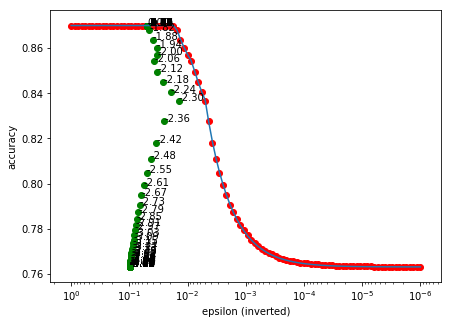

In [152]:
f, axs = plt.subplots(figsize=(7,5))
axs.semilogx(eps_used, acc_vals)
# x = np.log(post_process_meo)
axs.scatter(eps_used, post_process_acc, color='red')
axs.scatter(post_process_meo, post_process_acc, color='green')


axs.invert_xaxis()
axs.set_xlabel('epsilon (inverted)')
axs.set_ylabel('accuracy')

annotations = ['{:.2f}'.format(x) for x in np.log10(eps_used)]
for i, label in enumerate(annotations):
    plt.annotate(label, (post_process_meo[i], post_process_acc[i]))

filename = dataname + '_' + model_name 
plt.savefig(filename)

In [2]:
def post_process(model_name, dataname ):

    # if model_name == 'logit':
    #     model_names = ['LogisticRegression']
    # elif model_name == 'rf':
    #     model_names = ['RandomForest']
    # elif model_name == 'gbm':
    #     model_names = ['GradientBoost']
    # result = create_and_train_models(model_names, dtypes_, X_train_removed, y_train, 
    #                              X_test=X_test_removed, y_test=y_test, save=True, data_name=dataname)


    # grid = result[0]['estimator']
    # filename = dataname + '-' + model_name + '.pkl'
    # with open(filename, 'wb') as f:
    #     pickle.dump(grid, f)

    fm = FairnessMeasures(X_train, y_train, X_test, y_test, X_train_removed, X_test_removed, 
                        grid, sex_idx, pos_label=1, neg_label=0)

    _, mats_dict, M_const, b_const = get_fairness_mats(fm)

    # Post process
    A, b = mats_dict['EqOdd']
    A_const = M_const

    eps_vals = np.logspace(0, -6, 100)
    eps_used = []
    acc_vals = []
    for eps in eps_vals:
        try:
            res, _ = model_spec_solve(A, b, A_const, b_const, fm, eps=eps)
            acc_vals.append(1 - res.value)
            eps_used.append(eps)
        except:
            continue

    # acc_target = 0.65

    # eps_targets = np.array(eps_used)[np.array(acc_vals) > acc_target]
    # print(eps_targets)

    eps_targets=[1]
    # eps_mean, acc_mean = [], []

    for eps in eps_targets:
        fact_sol_eps = []
        fact_sol_acc = []
        print(eps)
        res, sol = model_spec_solve(A, b, A_const, b_const, fm, eps=eps)
        if res.status == 'infeasible':
            print('early quit: %f'%eps)
            break
        #print(eps, 1- res.value)
        zz = sol.value
        # get mixing rates

        # base classifier
        fpr_base_pos = fm.pos_group_stats['FPR']
        tpr_base_pos = fm.pos_group_stats['TPR']
        fnr_base_pos = fm.pos_group_stats['FNR']
        tnr_base_pos = fm.pos_group_stats['TNR']
        fpr_base_neg = fm.neg_group_stats['FPR']
        tpr_base_neg = fm.neg_group_stats['TPR']
        fnr_base_neg = fm.neg_group_stats['FNR']
        tnr_base_neg = fm.neg_group_stats['TNR']

        # derived classifier
        fpr_der_pos = zz[2] / (zz[2] + zz[3])
        tpr_der_pos = zz[0] / (zz[0] + zz[1])
        fnr_der_pos = 1 - tpr_der_pos
        tnr_der_pos = 1 - fpr_der_pos
        fpr_der_neg = zz[6] / (zz[6] + zz[7])
        tpr_der_neg = zz[4] / (zz[4] + zz[5])
        fnr_der_neg = 1 - tpr_der_neg
        tnr_der_neg = 1 - fpr_der_neg
        
        for i in range(10):

            # get mixing rates
            mix_mat_pos = np.array([[tpr_base_pos, fnr_base_pos, 0, 0], [fpr_base_pos, tnr_base_pos, 0, 0], [0, 0, tpr_base_pos, fnr_base_pos], [0, 0, fpr_base_pos, tnr_base_pos]])
            mix_b_pos = np.array([tpr_der_pos, fpr_der_pos, fnr_der_pos, tnr_der_pos])
            mix_sol_pos = np.linalg.solve(mix_mat_pos, mix_b_pos)
            mix_mat_neg = np.array([[tpr_base_neg, fnr_base_neg, 0, 0], [fpr_base_neg, tnr_base_neg, 0, 0], [0, 0, tpr_base_neg, fnr_base_neg], [0, 0, fpr_base_neg, tnr_base_neg]])
            mix_b_neg = np.array([tpr_der_neg, fpr_der_neg, fnr_der_neg, tnr_der_neg])
            mix_sol_neg = np.linalg.solve(mix_mat_neg, mix_b_neg)
            p2p_pos, n2p_pos, p2n_pos, n2n_pos = mix_sol_pos
            p2p_neg, n2p_neg, p2n_neg, n2n_neg = mix_sol_neg

            # Post-process accordingly
            pos_pred = fm.y_pred[fm.pos_group]
            pos_pred_fair = pos_pred.copy()
            pos_pp_indices, = np.nonzero(pos_pred)
            pos_pn_indices, = np.nonzero(1 - pos_pred)
            np.random.seed(i)
            np.random.shuffle(pos_pp_indices)
            np.random.seed(i)
            np.random.shuffle(pos_pn_indices)
            n2p_indices = pos_pn_indices[:int(len(pos_pn_indices) * n2p_pos)]
            pos_pred_fair[n2p_indices] = 1 - pos_pred_fair[n2p_indices]
            p2n_indices = pos_pp_indices[:int(len(pos_pp_indices) * (1 - p2p_pos))]
            pos_pred_fair[p2n_indices] = 1 - pos_pred_fair[p2n_indices]

            neg_pred = fm.y_pred[fm.neg_group]
            neg_pred_fair = neg_pred.copy()
            neg_pp_indices, = np.nonzero(neg_pred)
            neg_pn_indices, = np.nonzero(1 - neg_pred)
            np.random.shuffle(neg_pp_indices)
            np.random.shuffle(neg_pn_indices)
            n2p_indices = neg_pn_indices[:int(len(neg_pn_indices) * n2p_neg)]
            neg_pred_fair[n2p_indices] = 1 - neg_pred_fair[n2p_indices]
            p2n_indices = neg_pp_indices[:int(len(neg_pp_indices) * (1 - p2p_neg))]
            neg_pred_fair[p2n_indices] = 1 - neg_pred_fair[p2n_indices]

            # Measure performance

            # EOd gap and accuracy
            fn_pos = np.where(pos_pred_fair - fm.y_test[fm.pos_group] == -1)[0].shape[0]
            fp_pos = np.where(pos_pred_fair - fm.y_test[fm.pos_group] == 1)[0].shape[0]
            eod_pos = (fn_pos / fm.pos_group_num, fp_pos / fm.pos_group_num)

            fn_neg = np.where(neg_pred_fair - fm.y_test[fm.neg_group] == -1)[0].shape[0]
            fp_neg = np.where(neg_pred_fair - fm.y_test[fm.neg_group] == 1)[0].shape[0]
            eod_neg = (fn_neg / fm.neg_group_num, fp_neg / fm.neg_group_num)

            eod_gap = np.abs(eod_pos[0] - eod_neg[0]) + np.abs(eod_pos[1] - eod_neg[1])
            meo = eod_gap/2
            acc = 1 - (fn_pos + fp_pos + fn_neg + fp_neg) / fm.y_test.shape[0] 
            print(eod_gap, acc)
            fact_sol_eps.append(meo)
            fact_sol_acc.append(acc)
            
        # eps_mean.append(fact_sol_eps)
        # acc_mean.append(fact_sol_acc)
        
    return {'meo': fact_sol_eps, 'acc': fact_sol_acc}




In [22]:
# dataname = 'adult'
# model_name = 'gbm'

for dataname in ['adult']:
    for model_name in ['rf']:
        trade_off = post_process(model_name, dataname)
        result_filename = dataname+'_fact_'+model_name+'_eo_s42.pkl'
        with open(result_filename, 'wb+') as f:
            pickle.dump(trade_off, f)

Training {'estimator': GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='ignore', n_values='auto', sparse=False)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestclassifier', RandomForestClassifier(bootstrap...estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False))]),
       fit_params=None, iid=False, n_jobs=1,
       param_grid={'randomforestclassifier__max_depth': [4, 5, 6], 'randomforestclassifier__n_estimators': [100, 200, 400]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0), 'get_model': <function create_model.<locals>.get_model at 0x7faafaf00f28>, 'model_name': 'RandomForest'}
0.0032745491628777285
0.7987634684545762

In [23]:
trade_off


{'meo': [0.3993817342272881,
  0.3993817342272881,
  0.3993817342272882,
  0.3993817342272881,
  0.3993817342272881,
  0.3993817342272881,
  0.3993817342272881,
  0.3993817342272881,
  0.3993817342272882,
  0.3993817342272882],
 'acc': [0.5002559115569659,
  0.49943699457467494,
  0.49984645306582043,
  0.5000511823113931,
  0.49902753608352957,
  0.49923226532910225,
  0.49984645306582043,
  0.49964172382024774,
  0.49882280683795677,
  0.49984645306582043],
 'time': [213.7667691707611,
  213.76846313476562,
  213.770005941391,
  213.7740728855133,
  213.77618598937988,
  213.77842020988464,
  213.7813549041748,
  213.78311204910278,
  213.78440308570862,
  213.785578250885]}

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='ignore', n_values='auto', sparse=False)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestclassifier', RandomForestClassifier(bootstrap...estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False))]),
       fit_params=None, iid=False, n_jobs=1,
       param_grid={'randomforestclassifier__max_depth': [4, 5, 6], 'randomforestclassifier__n_estimators': [100, 200, 400]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)
[1.00000000e+00 8.69749003e-01 7.56463328e-01 6.57933225e-01
 5.72236766e-01 4.97702356e-01 4.32876128e-01 3.76493581e-01
 3.27454916e-01 2.84803587e-01 2.47707636e-01 2

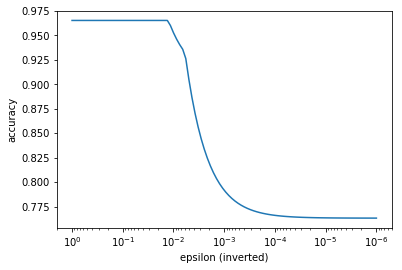

In [24]:
dataname='adult'
X_train, y_train, X_test, y_test, X_train_removed, X_test_removed, dtypes, dtypes_, sens_idc, race_idx, sex_idx = get_dataset(dataname)

grid = pickle.load(open('adult-rf.pkl', 'rb'))
# grid = result[i]['estimator']
print(grid)
# Get fairness matrix information
fm = FairnessMeasures(X_train, y_train, X_test, y_test, X_train_removed, X_test_removed, 
                    grid, sex_idx, pos_label=1, neg_label=0)

mats, mats_dict, M_const, b_const = get_fairness_mats(fm)

# Post process
A, b = mats_dict['EqOdd']
A_const = M_const

eps_vals = np.logspace(0, -6, 100)
eps_used = []
acc_vals = []
for eps in eps_vals:
    try:
        res, _ = model_spec_solve(A, b, A_const, b_const, fm, eps=eps)
        acc_vals.append(1 - res.value)
        eps_used.append(eps)
    except:
        continue

f, axs = plt.subplots()
axs.semilogx(eps_used, acc_vals)
axs.invert_xaxis()
axs.set_xlabel('epsilon (inverted)')
axs.set_ylabel('accuracy')

acc_target = 0.55

eps_targets = np.array(eps_used)[np.array(acc_vals) > acc_target]
print(eps_targets)

# eps_targets=[1]
eps_mean, acc_mean = [], []

for eps in eps_targets:
    fact_sol_eps = []
    fact_sol_acc = []
    print(eps)
    res, sol = model_spec_solve(A, b, A_const, b_const, fm, eps=eps)
    if res.status == 'infeasible':
        print('early quit: %f'%eps)
        break
    #print(eps, 1- res.value)
    zz = sol.value
    # get mixing rates

    # base classifier
    fpr_base_pos = fm.pos_group_stats['FPR']
    tpr_base_pos = fm.pos_group_stats['TPR']
    fnr_base_pos = fm.pos_group_stats['FNR']
    tnr_base_pos = fm.pos_group_stats['TNR']
    fpr_base_neg = fm.neg_group_stats['FPR']
    tpr_base_neg = fm.neg_group_stats['TPR']
    fnr_base_neg = fm.neg_group_stats['FNR']
    tnr_base_neg = fm.neg_group_stats['TNR']

    # derived classifier
    fpr_der_pos = zz[2] / (zz[2] + zz[3])
    tpr_der_pos = zz[0] / (zz[0] + zz[1])
    fnr_der_pos = 1 - tpr_der_pos
    tnr_der_pos = 1 - fpr_der_pos
    fpr_der_neg = zz[6] / (zz[6] + zz[7])
    tpr_der_neg = zz[4] / (zz[4] + zz[5])
    fnr_der_neg = 1 - tpr_der_neg
    tnr_der_neg = 1 - fpr_der_neg
    
    for i in range(10):

        # get mixing rates
        mix_mat_pos = np.array([[tpr_base_pos, fnr_base_pos, 0, 0], [fpr_base_pos, tnr_base_pos, 0, 0], [0, 0, tpr_base_pos, fnr_base_pos], [0, 0, fpr_base_pos, tnr_base_pos]])
        mix_b_pos = np.array([tpr_der_pos, fpr_der_pos, fnr_der_pos, tnr_der_pos])
        mix_sol_pos = np.linalg.solve(mix_mat_pos, mix_b_pos)
        mix_mat_neg = np.array([[tpr_base_neg, fnr_base_neg, 0, 0], [fpr_base_neg, tnr_base_neg, 0, 0], [0, 0, tpr_base_neg, fnr_base_neg], [0, 0, fpr_base_neg, tnr_base_neg]])
        mix_b_neg = np.array([tpr_der_neg, fpr_der_neg, fnr_der_neg, tnr_der_neg])
        mix_sol_neg = np.linalg.solve(mix_mat_neg, mix_b_neg)
        p2p_pos, n2p_pos, p2n_pos, n2n_pos = mix_sol_pos
        p2p_neg, n2p_neg, p2n_neg, n2n_neg = mix_sol_neg

        # Post-process accordingly
        pos_pred = fm.y_pred[fm.pos_group]
        pos_pred_fair = pos_pred.copy()
        pos_pp_indices, = np.nonzero(pos_pred)
        pos_pn_indices, = np.nonzero(1 - pos_pred)
        np.random.seed(i)
        np.random.shuffle(pos_pp_indices)
        np.random.seed(i)
        np.random.shuffle(pos_pn_indices)
        n2p_indices = pos_pn_indices[:int(len(pos_pn_indices) * n2p_pos)]
        pos_pred_fair[n2p_indices] = 1 - pos_pred_fair[n2p_indices]
        p2n_indices = pos_pp_indices[:int(len(pos_pp_indices) * (1 - p2p_pos))]
        pos_pred_fair[p2n_indices] = 1 - pos_pred_fair[p2n_indices]

        neg_pred = fm.y_pred[fm.neg_group]
        neg_pred_fair = neg_pred.copy()
        neg_pp_indices, = np.nonzero(neg_pred)
        neg_pn_indices, = np.nonzero(1 - neg_pred)
        np.random.shuffle(neg_pp_indices)
        np.random.shuffle(neg_pn_indices)
        n2p_indices = neg_pn_indices[:int(len(neg_pn_indices) * n2p_neg)]
        neg_pred_fair[n2p_indices] = 1 - neg_pred_fair[n2p_indices]
        p2n_indices = neg_pp_indices[:int(len(neg_pp_indices) * (1 - p2p_neg))]
        neg_pred_fair[p2n_indices] = 1 - neg_pred_fair[p2n_indices]

        # Measure performance

        # EOd gap and accuracy
        fn_pos = np.where(pos_pred_fair - fm.y_test[fm.pos_group] == -1)[0].shape[0]
        fp_pos = np.where(pos_pred_fair - fm.y_test[fm.pos_group] == 1)[0].shape[0]
        eod_pos = (fn_pos / fm.pos_group_num, fp_pos / fm.pos_group_num)

        fn_neg = np.where(neg_pred_fair - fm.y_test[fm.neg_group] == -1)[0].shape[0]
        fp_neg = np.where(neg_pred_fair - fm.y_test[fm.neg_group] == 1)[0].shape[0]
        eod_neg = (fn_neg / fm.neg_group_num, fp_neg / fm.neg_group_num)

        eod_gap = np.abs(eod_pos[0] - eod_neg[0]) + np.abs(eod_pos[1] - eod_neg[1])
        meo = eod_gap/2
        acc = 1 - (fn_pos + fp_pos + fn_neg + fp_neg) / fm.y_test.shape[0] 
        print(eod_gap, acc)
        fact_sol_eps.append(meo)
        fact_sol_acc.append(acc)
        
    eps_mean.append(fact_sol_eps)
    acc_mean.append(fact_sol_acc)
    
trade_off = {'meo': eps_mean, 'acc': acc_mean}
        


Text(0.5, 0, 'MEO')

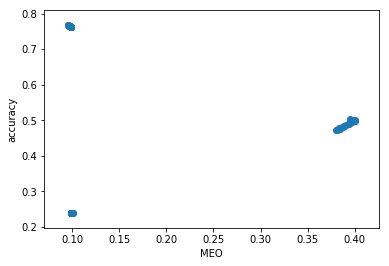

In [25]:
eps_avg = np.array(eps_mean).mean(axis=1)
acc_avg = np.array(acc_mean).mean(axis=1)

plt.scatter(eps_avg, acc_avg)
plt.ylabel('accuracy')
plt.xlabel('MEO')

Text(0.5, 0, 'epsilon')

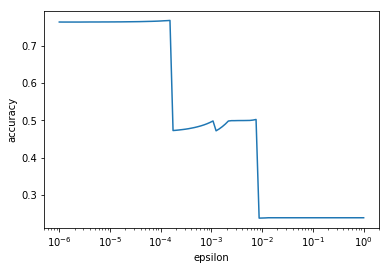

In [26]:
plt.plot(eps_targets, acc_avg)
plt.xscale('log')
plt.ylabel('accuracy')
plt.xlabel('epsilon')

In [27]:
min_idx = np.argmax(acc_avg)
eps_avg[min_idx], acc_avg[min_idx], eps_used[min_idx], min_idx

(0.09553221680720891, 0.767529941652165, 0.0001519911082952933, 63)

In [57]:
with open('enem_fact_logit_eo_s42.pkl', 'wb+') as f:
    pickle.dump(trade_off[0], f)

In [44]:
print(trade_off[0]['acc_mean'])
print(trade_off[0]['meo_mean'])


[[0.6738666666666666, 0.6738666666666666, 0.6738666666666666, 0.6738666666666666, 0.6738666666666666, 0.6738666666666666, 0.6738666666666666, 0.6738666666666666, 0.6738666666666666, 0.6738666666666666]]
[[0.049284858292390626, 0.049284858292390626, 0.049284858292390626, 0.049284858292390626, 0.049284858292390626, 0.049284858292390626, 0.049284858292390626, 0.049284858292390626, 0.049284858292390626, 0.049284858292390626]]


In [34]:
print(trade_off[1]['acc_mean'])
print(trade_off[1]['meo_mean'])

[0.6617333333333333]
[0.05165846885898937]


In [27]:
with open('../../adult/results/eqodds_gbm_s42_withS.pkl', 'rb') as f:
    x = pickle.load(f)

In [28]:
x

{'sp_mean': [0.09182240428310487],
 'sp_std': [0.012858167609696007],
 'avgeo_mean': [0.018415719642183775],
 'avgeo_std': [0.015765457899439395],
 'abseo_mean': [0.0221374678385427],
 'abseo_std': [0.015984862166890986],
 'maxeo_mean': [0.017948138337241022],
 'maxeo_std': [0.02749266566528946],
 'acc_mean': [0.8406142365097589],
 'acc_std': [0.006728672815924325],
 'brier_mean': [0.09480382138150456],
 'brier_std': [0.0029121147851727354],
 'time_mean': [1.6529888391494751],
 'time_std': [0.1555224407828379]}

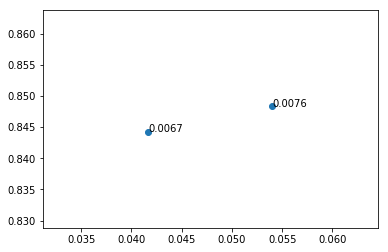

In [37]:
plt.scatter(eps_mean, acc_mean)
eps_text = [f'{x:.4f}' for x in list(eps_targets)]

for i, txt in enumerate(eps_text):
    plt.annotate(txt, (eps_mean[i], acc_mean[i]))

NameError: name 'eqodd_results' is not defined

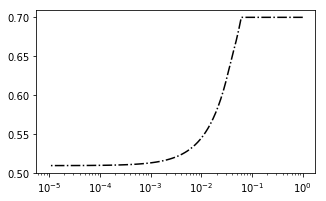

In [19]:
A_eod, b_eod = mats_dict['EqOdd']
A_cg, b_cg = mats_dict['Calibration']
A_dp, b_dp = mats_dict['DemoParity']
A_const = M_const

A1, b1 = A_eod, b_eod 
A2, b2 = np.vstack((A_eod, A_cg)), np.vstack((b_eod, b_cg))
A3, b3 = np.vstack((A_eod, A_dp)), np.vstack((b_eod, b_dp))

lst_mat = [(A1, b1)]
color = ['k']
name = ['EOd']

f, axs = plt.subplots(figsize=(5,3))
for i, (A, b) in enumerate(lst_mat):
    eps_vals = np.logspace(0, -5, 100)
    eps_used = []
    acc_vals = []
    failed_point = None
    for eps in eps_vals:
        res, _ = model_spec_solve(A, b, A_const, b_const, fm, eps=eps)
        if res.status != 'infeasible':
            acc_vals.append(1 - res.value)
            eps_used.append(eps)
        else:
            failed_point = eps
            break
    axs.semilogx(eps_used, acc_vals, color=color[i], linestyle='-.', label='MS FACT Frontier (%s)'%name[i])
    if failed_point != None:
        axs.scatter([failed_point], [acc_vals[-1]], marker='X', color=color[i], s=100, label='incompatible')

eqodd_points_before_x = [e[0][0] for e in eqodd_results]
eqodd_points_before_y = [e[0][1] for e in eqodd_results]
eqodd_points_after_x = [e[1][0] for e in eqodd_results]
eqodd_points_after_y = [e[1][1] for e in eqodd_results]
axs.scatter(eqodd_points_before_x, eqodd_points_before_y, label='before', color='k', marker='x', alpha=0.5)
axs.scatter(eqodd_points_after_x, eqodd_points_after_y, label='EOd-solution', color='k', marker='o', alpha=0.5)
axs.scatter(fact_sol_eps, fact_sol_acc, label='FACT-solution', color = 'k', marker='*', s=70)

# pickle.dump([eps_used, acc_vals], open('postprocess_curve_cg.pkl', 'wb'))
axs.invert_xaxis()
axs.legend(frameon=False)
axs.set_ylabel('Accuracy (1 - $\delta$)', fontsize=13)
axs.set_xlabel('Fairness Gap ($\epsilon$)', fontsize=13)
plt.tight_layout()
plt.savefig('post.pdf', bbox_inches='tight', dpi=200)

In [ ]:
#### Seleect Dataset #### 
dataname='enem'

#### Load Dataset #### 
X_train, y_train, X_test, y_test, X_train_removed, X_test_removed, dtypes, dtypes_, sens_idc, race_idx, sex_idx = get_dataset(dataname)

### Generate Grid #### 
model_list = ['logit', 'rf', 'gbm'] 
for model_name in model_list: 
    if model_name == 'logit':
        model_names = ['LogisticRegression']
    elif model_name == 'rf':
        model_names = ['RandomForest']
    elif model_name == 'gbm':
        model_names = ['GradientBoost']
    result = create_and_train_models(model_names, dtypes_, X_train_removed, y_train, 
                                 X_test=X_test_removed, y_test=y_test, save=True, data_name=dataname)

    filename = dataname + '-' + model_name + '.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(result[0]['estimator'], f)

        

Training {'estimator': GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(categorical_features=array([ True,  True, ...,  True, False]),
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values='auto', sparse=False)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregress...alty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=False, n_jobs=1,
       param_grid={'logisticregression__C': array([0.0001, 0.1   ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0), 'get_model': <function create_model.<locals>.get_model at 0x7fa7a1786f28>, 'model_name': 'LogisticRegression'}
